### Imports

In [646]:
import random
import collections
from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from spacy import cli
import torch
import transformers as ppb
import warnings
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import umap
import hdbscan

warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (10,6)

### Prepare Data

In [647]:
bigdata = pd.read_csv("/Users/gustagol_jr/Documents/GitHub/MLCountryMarket/ML/TheCountryMarketAnswers.csv")

In [648]:
del bigdata['Timestamp']
bigdata['Missing'].fillna('N/a',inplace=True)

In [649]:
bigdata.head(10)

,Town,Retailers,Distance,Frequency,LastPurchased,LocallyOwn,Missing,Resolve,PurchaseFreshFood,DistanceFreshFood,...,SmallerPacketsImpact,More,LocallyOwnedPast,WhyClosed,HowMuchWantFreshFood,HowWouldImpact,HowLikelyToShopThere,SmallerPacketsImpactPlan,SpentOnGroceries,TopThreeFoods
0,"South Bend, Indiana",2,Between 3 miles and 5 miles,3-4 times per week,"Dollar General/Dollar Tree, Walmart, Costco",Yes,knkmknkn,lkkjnkl,NaN,NaN,...,NaN,m m,NaN,NaN,NaN,NaN,NaN,NaN,$751-$1000,"Canned food, Alcoholic Beverages, Dry/baking g..."
1,Town of Milford,1,Less than 3 miles,1-2 times per week,"Dollar General/Dollar Tree, Walmart, Costco, M...",No,Fresh Produce,"Fresh affordable, quality produce available ye...",NaN,NaN,...,NaN,NaN,Yes,I have no idea,5.0,I would be able to have fresh fruits and veget...,5.0,1.0,$501-$750,"Dairy, Frozen foods, Dry/baking goods"
2,LaPaz,2,Less than 3 miles,1-2 times per week,"Dollar General/Dollar Tree, Martin's, Kroger, ...",Yes,larger variety,LaPaz only has Mac's Market and Dollar General...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,$0-$250,"Non-alcoholic beverage, Frozen foods, Meat"
3,Galien mi,2,Less than 3 miles,1-2 times per week,"Walmart, Meijer",Maybe,Fresh produce,Local delivery from Whole Foods or independent...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,$251-$500,"Non-alcoholic beverage, Meat, Dry/baking goods"
4,Bremen,3,Between 5 and 10 miles,1-2 times per week,"Costco, Martin's, Kroger, Local grocery store",Yes,Good fresh produce,"Better suppliers, working with local farmers",NaN,NaN,...,NaN,Quality of products has drastically decreased ...,NaN,NaN,NaN,NaN,NaN,NaN,$501-$750,"Bread/bakery, Dairy, Meat"
5,"Wakarusa, IN",2,Less than 3 miles,1-2 times per week,"Dollar General/Dollar Tree, Meijer, Aldi",Yes,N/a,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,$501-$750,"Bread/bakery, Dairy, Meat"
6,"Wakarusa, IN",1,Less than 3 miles,1-2 times per week,"Dollar General/Dollar Tree, Costco, Martin's, ...",No,more fresh/healthy options,trader joes,NaN,NaN,...,NaN,NaN,No,No idea,5.0,I would shop there all the time.,5.0,1.0,$1001-$1250,"Bread/bakery, Meat"
7,"North Liberty, IN",2,Less than 3 miles,1-2 times per week,"Costco, Martin's, Meijer",Yes,"I don't shop at the Dollar General, but the lo...",Not sure what the best solution is because you...,NaN,NaN,...,NaN,It's a butcher shop and they have some amazing...,NaN,NaN,NaN,NaN,NaN,NaN,$251-$500,"Dairy, Meat, Dry/baking goods"
8,Warsaw,5+,Between 3 miles and 5 miles,1-2 times per week,"Walmart, Kroger, Meijer",No,Grocery Store other than Dollar General close ...,Someone that would want to open a new grocery ...,NaN,NaN,...,NaN,NaN,Yes,No idea,5.0,Easier access for those who can't get to the o...,5.0,5.0,$0-$250,"Dairy, Frozen foods, Meat"
9,Wakarusa,2,Less than 3 miles,1-2 times per week,"Dollar General/Dollar Tree, Local grocery stor...",No,More fresh food,"I don’t know, small demographic does not allow...",NaN,NaN,...,NaN,NaN,Yes,Town was too small to support big stores have ...,5.0,Yes,5.0,3.0,$501-$750,"Dairy, Alcoholic Beverages, Meat"


In [650]:
data = bigdata[['Town','Missing']].copy()


### Tokenize

In [651]:
model_class, tokenizer_class, pretreined_weights = (ppb.BertModel, ppb.BertTokenizer,'bert-base-uncased')

tokenizer = tokenizer_class.from_pretrained(pretreined_weights)

model = model_class.from_pretrained(pretreined_weights)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [652]:
tokenized = data['Missing'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
tokenized

0             [101, 14161, 22287, 2243, 8950, 2078, 102]
1                                 [101, 4840, 3965, 102]
2                                 [101, 3469, 3528, 102]
3                                 [101, 4840, 3965, 102]
4                           [101, 2204, 4840, 3965, 102]
                             ...                        
137    [101, 4840, 3965, 1010, 2204, 6240, 2533, 1010...
138    [101, 2632, 4305, 2030, 16269, 2544, 1997, 130...
139      [101, 15184, 1998, 2152, 3737, 4840, 3965, 102]
140                                     [101, 2498, 102]
141            [101, 3029, 1013, 3688, 2006, 15475, 102]
Name: Missing, Length: 142, dtype: object

In [653]:
max_len = 0

for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)
        
padded = np.array([i+[0]*(max_len-len(i)) for i in tokenized.values])

padded = np.array([list(x[:512]) for x in padded])

np.array(padded).shape

(142, 66)

In [654]:
attention_mask = np.where(padded != 0,1,0)
attention_mask.shape

(142, 66)

In [655]:
input_ids = torch.tensor(padded)
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids,attention_mask = attention_mask)

In [656]:
features = last_hidden_states[0][:,0,:].numpy()
features.shape

(142, 768)

### Clustering

In [657]:
umap_embeddings = umap.UMAP(n_neighbors=5,n_components=5,metric = 'cosine',random_state=32).fit_transform(features)
cluster = hdbscan.HDBSCAN(min_cluster_size=10,
                          metric = 'euclidean',
                          cluster_selection_method='eom').fit(umap_embeddings)

In [658]:
cluster.labels_

array([ 1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  1,
        0,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  0,  1,  0,  1,  1,  1,
        1, -1,  1,  1,  1,  0, -1,  1,  1,  1,  0,  1,  1,  1,  1,  0,  1,
        1,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  0,  1])

In [659]:
# Prepare data to visualize
umap_data = umap.UMAP(n_neighbors=5, n_components=2, min_dist=0.0, metric='cosine',random_state=5).fit_transform(features)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_



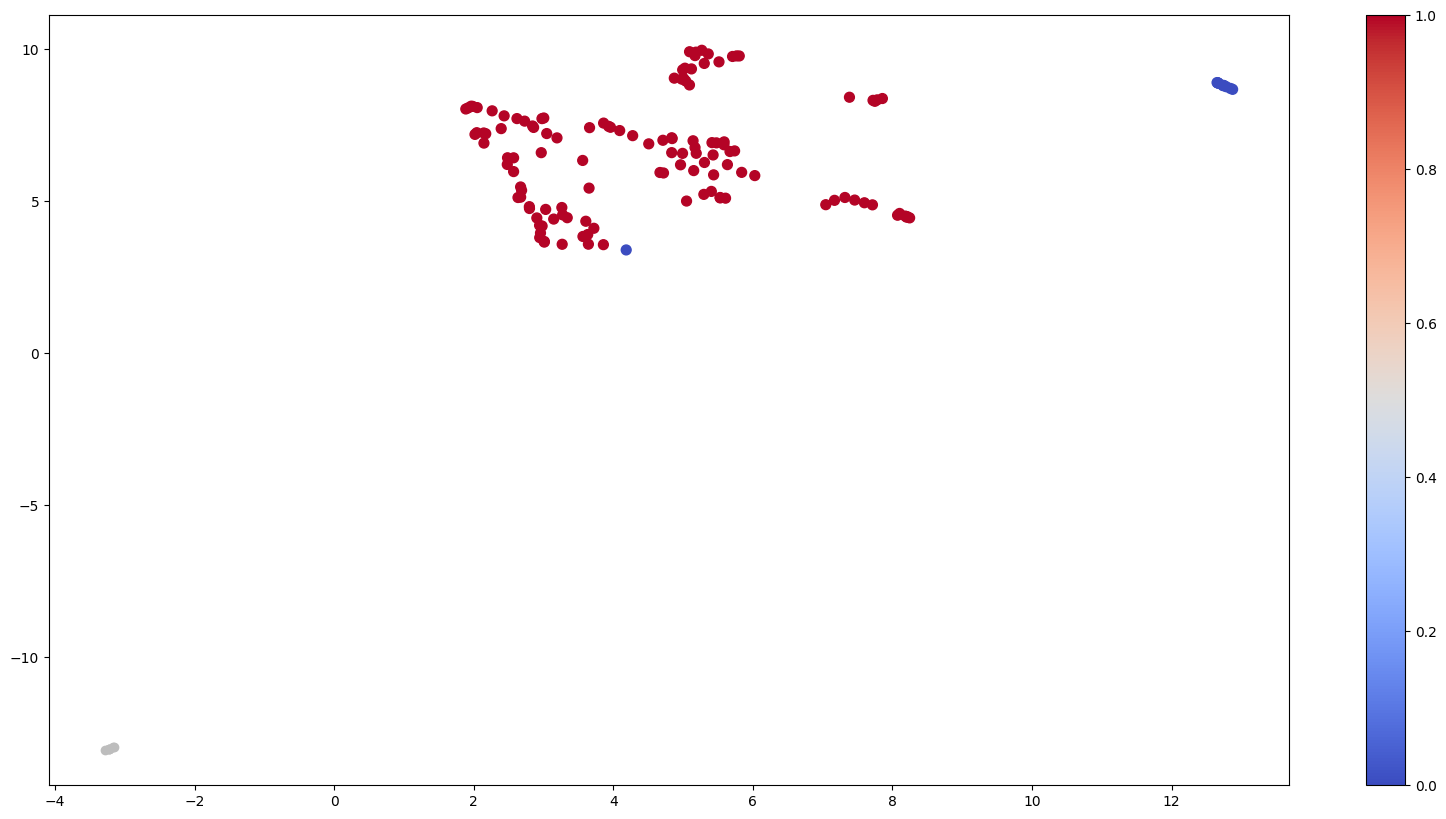

In [660]:
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD')
plt.scatter(clustered.x, clustered.y, c=clustered.labels, cmap='coolwarm',s=50)
plt.colorbar()

In [661]:
data['labels'] = cluster.labels_
data.head(10)

,Town,Missing,labels
0,"South Bend, Indiana",knkmknkn,1
1,Town of Milford,Fresh Produce,1
2,LaPaz,larger variety,1
3,Galien mi,Fresh produce,1
4,Bremen,Good fresh produce,1
5,"Wakarusa, IN",N/a,-1
6,"Wakarusa, IN",more fresh/healthy options,1
7,"North Liberty, IN","I don't shop at the Dollar General, but the lo...",1
8,Warsaw,Grocery Store other than Dollar General close ...,1
9,Wakarusa,More fresh food,1


In [662]:
data.loc[data['labels']==0]

,Town,Missing,labels
41,Bremen,Nothing,0
66,Knox,Nothing really.,0
68,"Plymouth, IN",nothing,0
79,Aldine,Nothing,0
81,Mishawaka,Nothing,0
90,Plymouth,Nothing,0
95,Plymouth,no idea,0
100,Plymouth,Nothing,0
103,Culver,nothing,0
119,Remington,Nothing,0


In [663]:
data.loc[data['labels']==1]

,Town,Missing,labels
0,"South Bend, Indiana",knkmknkn,1
1,Town of Milford,Fresh Produce,1
2,LaPaz,larger variety,1
3,Galien mi,Fresh produce,1
4,Bremen,Good fresh produce,1
...,...,...,...
136,"Grovertown, Indiana",We have no local grocery store. Would love fre...,1
137,Walkerton,"Fresh produce, good meat department, more options",1
138,Rome CIty,Aldi or cheaper version of grocery,1
139,"Leesburg, IN",affordable and high quality fresh produce,1


In [664]:
data.drop(data.loc[data['labels']==0].index,inplace=True)

In [665]:
model_class, tokenizer_class, pretreined_weights = (ppb.BertModel, ppb.BertTokenizer,'bert-base-uncased')

tokenizer = tokenizer_class.from_pretrained(pretreined_weights)

model = model_class.from_pretrained(pretreined_weights)

tokenized = data['Missing'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
tokenized

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0             [101, 14161, 22287, 2243, 8950, 2078, 102]
1                                 [101, 4840, 3965, 102]
2                                 [101, 3469, 3528, 102]
3                                 [101, 4840, 3965, 102]
4                           [101, 2204, 4840, 3965, 102]
                             ...                        
136    [101, 2057, 2031, 2053, 2334, 13025, 3573, 101...
137    [101, 4840, 3965, 1010, 2204, 6240, 2533, 1010...
138    [101, 2632, 4305, 2030, 16269, 2544, 1997, 130...
139      [101, 15184, 1998, 2152, 3737, 4840, 3965, 102]
141            [101, 3029, 1013, 3688, 2006, 15475, 102]
Name: Missing, Length: 131, dtype: object

In [666]:
max_len = 0

for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)
        
padded = np.array([i+[0]*(max_len-len(i)) for i in tokenized.values])

padded = np.array([list(x[:512]) for x in padded])

np.array(padded).shape

(131, 66)

In [667]:
attention_mask = np.where(padded != 0,1,0)
attention_mask.shape

(131, 66)

In [668]:
input_ids = torch.tensor(padded)
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids,attention_mask = attention_mask)

In [669]:
features = last_hidden_states[0][:,0,:].numpy()
features.shape

(131, 768)

In [670]:
umap_embeddings = umap.UMAP(n_neighbors=10,n_components=5,metric = 'cosine',random_state=32).fit_transform(features)
cluster = hdbscan.HDBSCAN(min_cluster_size=5,
                          metric = 'euclidean',
                          cluster_selection_method='eom').fit(umap_embeddings)

In [671]:
cluster.labels_

array([ 2, -1,  2,  4,  4,  1,  3,  0,  4,  4,  0,  4, -1,  0,  2,  2,  2,
        3,  4, -1, -1,  4,  0,  3,  0,  5, -1,  2,  0, -1, -1,  3,  3,  0,
       -1,  0,  1,  3,  0,  4, -1,  0,  0,  5,  0,  3,  0,  5, -1,  3,  3,
        0,  3, -1,  2,  1, -1,  5,  3,  2, -1,  1,  2, -1,  0,  5,  2,  3,
        0,  1,  0,  2, -1,  2,  2,  0,  3, -1,  3,  3, -1,  1,  3,  0,  5,
        1, -1,  3,  2, -1,  5,  5, -1,  4, -1,  3,  0,  2, -1,  1,  3,  5,
        3, -1,  4,  3,  2,  0,  0, -1,  0,  5,  4, -1,  0,  4,  2, -1,  2,
        4,  2,  4,  3,  3, -1,  4,  0,  3, -1,  4, -1])

In [672]:
# Prepare data to visualize
umap_data = umap.UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(features)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_



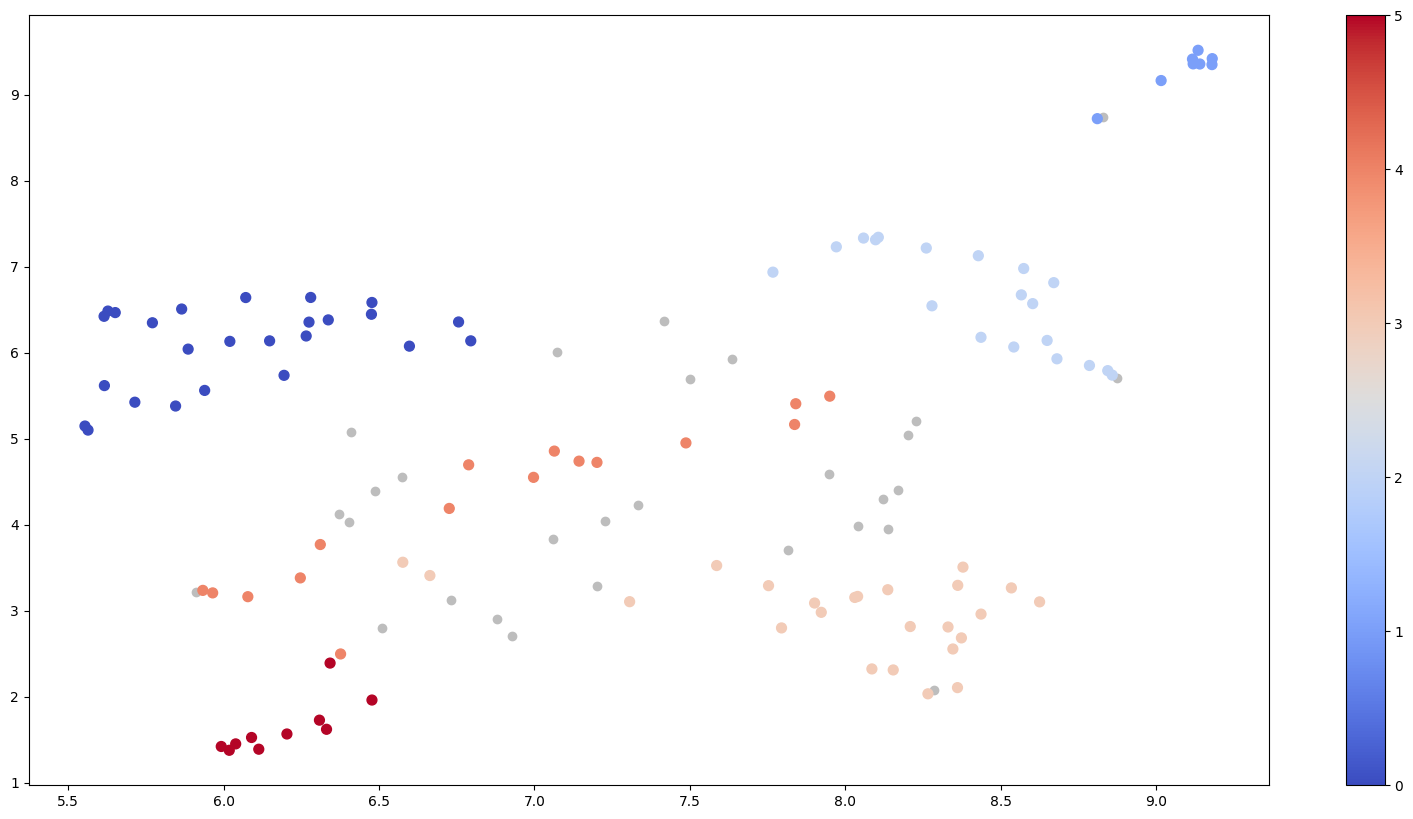

In [673]:
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD')
plt.scatter(clustered.x, clustered.y, c=clustered.labels, cmap='coolwarm',s=50)
plt.colorbar()

In [674]:
data['labels'] = cluster.labels_
data.head(10)

,Town,Missing,labels
0,"South Bend, Indiana",knkmknkn,2
1,Town of Milford,Fresh Produce,-1
2,LaPaz,larger variety,2
3,Galien mi,Fresh produce,4
4,Bremen,Good fresh produce,4
5,"Wakarusa, IN",N/a,1
6,"Wakarusa, IN",more fresh/healthy options,3
7,"North Liberty, IN","I don't shop at the Dollar General, but the lo...",0
8,Warsaw,Grocery Store other than Dollar General close ...,4
9,Wakarusa,More fresh food,4


In [692]:
data.loc[data['labels']==5]

,Town,Missing,labels
25,Elkhart,"Fresh, organic fruit and vegetables.",5
44,South bend,"Cat food, eggs, and chicken",5
48,"New Carlisle, Indiana",Organic produce and products.,5
58,Hamlet,Fresh vegetables and fruits,5
67,Town of Hamlet,Fresh fruits and veggies,5
89,North Liberty,Fresh fruit and vegetables,5
97,Lakeville IN.,Fresh produce and meat.,5
98,Lakeville,fresh vegetables,5
110,"Lakeville, IN",Fresh vegetables,5
121,"Chalmers, Indiana",produce and meats,5
